1288
1288
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
done in 0.269s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.017s
Fitting the classifier to the training set
done in 11.872s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)
Predicting people's names on the test set
done in 0.033s
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.46      0.57        13
     Colin Powell       0.80      0.88      0.84        60
  Donald Rumsfeld       0.90      0.67      0.77        27
    George W Bush       0.83      0.98      0.90       146
Gerhard Schroeder       1.00      0.76      0.86        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       0.97      0.81      0.88        36

         accuracy                           0.85       322
        macro avg       0.89      0.72      0

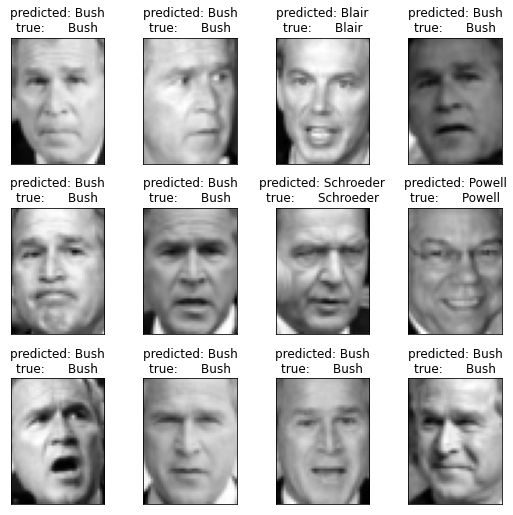

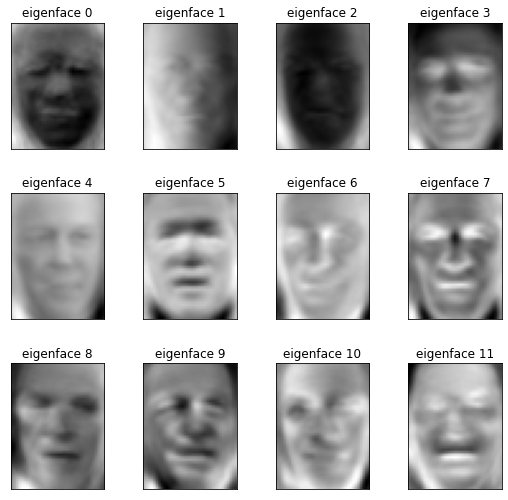

In [11]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(message)s")


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(minumber_of_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
number_of_samples, height, width = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
number_of_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
number_of_classes = target_names.shape[0]

print("Total dataset size:")
print("number_of_samples: %d" % number_of_samples)
print("number_of_features: %d" % number_of_features)
print("number_of_classes: %d" % number_of_classes)


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
number_of_components = 150

print(
    "Extracting the top %d eigenfaces from %d faces" % (number_of_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=number_of_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((number_of_components, height, width))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_trainumber_of_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": [1e3, 5e3, 1e4, 5e4, 1e5],
    "gamma": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}
clf = GridSearchCV(SVC(kernel="rbf", class_weight="balanced"), param_grid)
clf = clf.fit(X_trainumber_of_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(number_of_classes)))


# #############################################################################
# Qualitative evaluation of the predictions using matplotlib


def plot_gallery(images, titles, height, width, number_of_row=3, number_of_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * number_of_col, 2.4 * number_of_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(number_of_row * number_of_col):
        plt.subplot(number_of_row, number_of_col, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set


def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


predictionumber_of_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, predictionumber_of_titles, height, width)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, height, width)

plt.show()